In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

#Import pytorch:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

In [5]:
from src.spiking_network.network.neuvisys import SpikingNetwork
from src.spiking_network.analysis.spike_train import (
    spike_trains,
    kernel_convolution)

In [6]:
kernel_size = 20
sampling_size = 10

In [7]:
print("Loading network...")
network_path = "/home/thomas/Networks/simulation/supervised_learning/network_clockwise/"
spinet = SpikingNetwork(network_path, loading=[True, True, False, False])

print("Kernel convolution...")
sts = spike_trains(spinet.spikes[0])
X1 = kernel_convolution(sts, kernel_size, sampling_size)

ori = np.array(spinet.state["learning_data"]["reward"])
idx = np.round(np.linspace(0, len(ori) - 1, X1.shape[0])).astype(int)

Y1 = np.abs(ori[idx])
X1 = X1 / np.max(X1)

print(X1.shape, Y1.shape)

print("Loading network...")
network_path = "/home/thomas/Networks/simulation/supervised_learning/network_counterclockwise/"
spinet = SpikingNetwork(network_path, loading=[True, True, False, False])

print("Kernel convolution...")
sts = spike_trains(spinet.spikes[0])
X2 = kernel_convolution(sts, kernel_size, sampling_size)

ori = np.array(spinet.state["learning_data"]["reward"])
idx = np.round(np.linspace(0, len(ori) - 1, X2.shape[0])).astype(int)

Y2 = np.abs(ori[idx])
X2 = X2 / np.max(X2)

print(X2.shape, Y2.shape)

X = np.concatenate((X1, X2[:X1.shape[0]]))
Y = np.concatenate((Y1, Y2[:Y1.shape[0]]))

print(X.shape, Y.shape)

Loading network...
Kernel convolution...
(1000, 36864) (1000,)
Loading network...
Kernel convolution...
(1274, 36864) (1274,)
(2000, 36864) (2000,)


In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(36864, 1),
        )
        
    def forward(self, x):
        x = self.layer(x)
        return x

torch.manual_seed(0)
model = Net()
print(model)

Net(
  (layer): Sequential(
    (0): Linear(in_features=36864, out_features=1, bias=True)
  )
)


In [16]:
N_epochs = 300
batch_size = 100
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

In [17]:
x = torch.from_numpy(X).float()
y = torch.from_numpy(Y.reshape(-1,1)).float()
print(x.shape, y.shape)

torch.Size([2000, 36864]) torch.Size([2000, 1])


In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)

inputs = Variable(x_train)
outputs = Variable(y_train)
inputs_test = Variable(x_test)
outputs_test = Variable(y_test)

torch.Size([1600, 36864]) torch.Size([1600, 1])


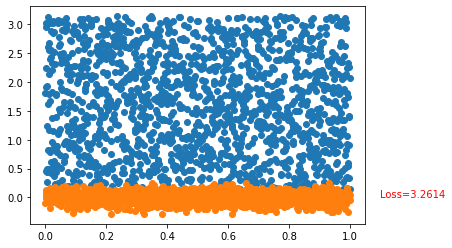

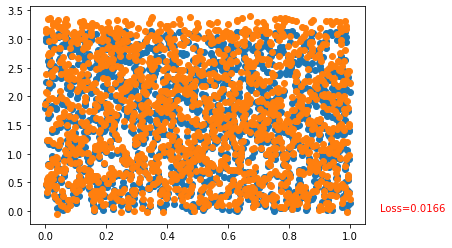

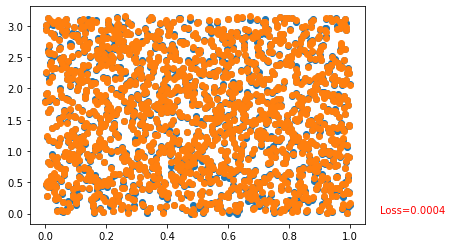

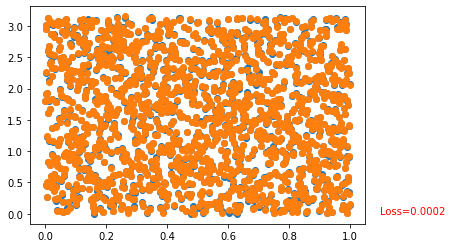

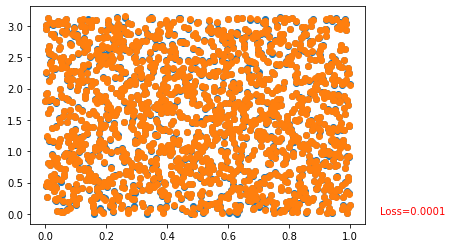

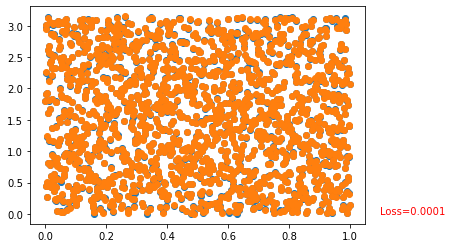

In [19]:
losses = []
for i in range(N_epochs):
    prediction = model(inputs)
    
    loss = loss_func(prediction, outputs)
    losses.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 50 == 0:
        plt.scatter(np.linspace(0, 1, y_train.data.numpy().shape[0]), y_train.data.numpy())
        plt.scatter(np.linspace(0, 1, y_train.data.numpy().shape[0]), prediction.data.numpy())
        plt.text(1.1, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color':  'red'})
    plt.show()

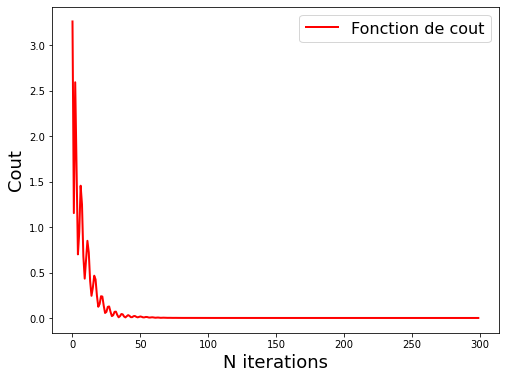

In [20]:
# Afficher l'évolution de la fonction de coût
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses, 'r-', lw=2, label='Fonction de cout')
axes.set_xlabel('N iterations', fontsize=18)
axes.set_ylabel('Cout', fontsize=18)
plt.legend(loc='upper right', fontsize=16)

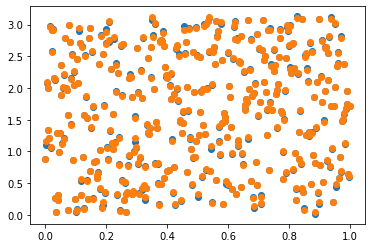

0.00023535259


In [22]:
with torch.no_grad():
    pred_test = model(inputs_test)
    mse = mean_squared_error(pred_test, y_test)
    plt.scatter(np.linspace(0, 1, y_test.data.numpy().shape[0]), y_test.data.numpy())
    plt.scatter(np.linspace(0, 1, y_test.data.numpy().shape[0]), pred_test.data.numpy())
    plt.show()
print(mse)